## References

* Credits to @abdulravoofshaik for his work in implementing an efficient LGBM model
* Notebook link: https://www.kaggle.com/code/abdulravoofshaik/top-3-solution-lgbm-mean

This code is aimed to help people find the best hyperparameters for LGBM using Bayesian Optimization tool.
TRAINING_SIZE variable enables to make tuning faster by taking only a sample of the dataset.
This is my first time implementing BO so any feedback is welcome !

In [1]:
# pip install bayesian-optimization

In [2]:
import random
import time 
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm


warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
PATH_DATA = "../input/tabular-playground-series-jun-2022/data.csv"
data = pd.read_csv(PATH_DATA, index_col='row_id')

In [4]:
data.shape

(1000000, 80)

In [5]:
data

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
row_id,,,,,,,,,,,,,,,,,,,,,
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,NaN,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502


<AxesSubplot:>

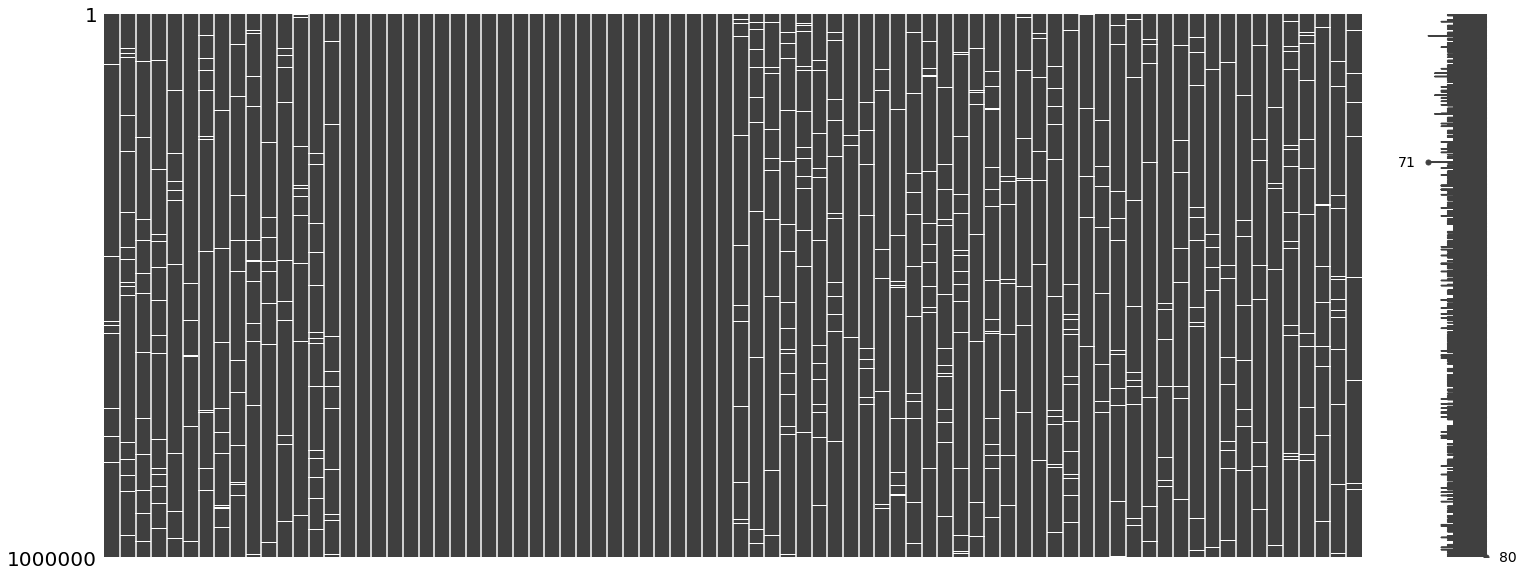

In [6]:
msno.matrix(data)

In [7]:
nans_percentage = data.isna().sum().sum() / data.size * 100
print(f"Dataset contains {nans_percentage} % of Nans")

Dataset contains 1.25 % of Nans


In [8]:
data.dtypes.value_counts()

float64    55
int64      25
dtype: int64

In [9]:
# shows only int64 columns

mask_int64 = data.dtypes == 'int64'
data.loc[:, data.columns[mask_int64]].columns

Index(['F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6', 'F_2_7',
       'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14',
       'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20', 'F_2_21',
       'F_2_22', 'F_2_23', 'F_2_24'],
      dtype='object')

In [10]:
list_col_2 = [col for col in data.columns if col.split('_')[1] == '2']
data_col_2 = data[list_col_2]

print(f"Columns starting with F_2 have \
{data_col_2.isna().sum().sum()} Nans")

Columns starting with F_2 have 0 Nans


<AxesSubplot:>

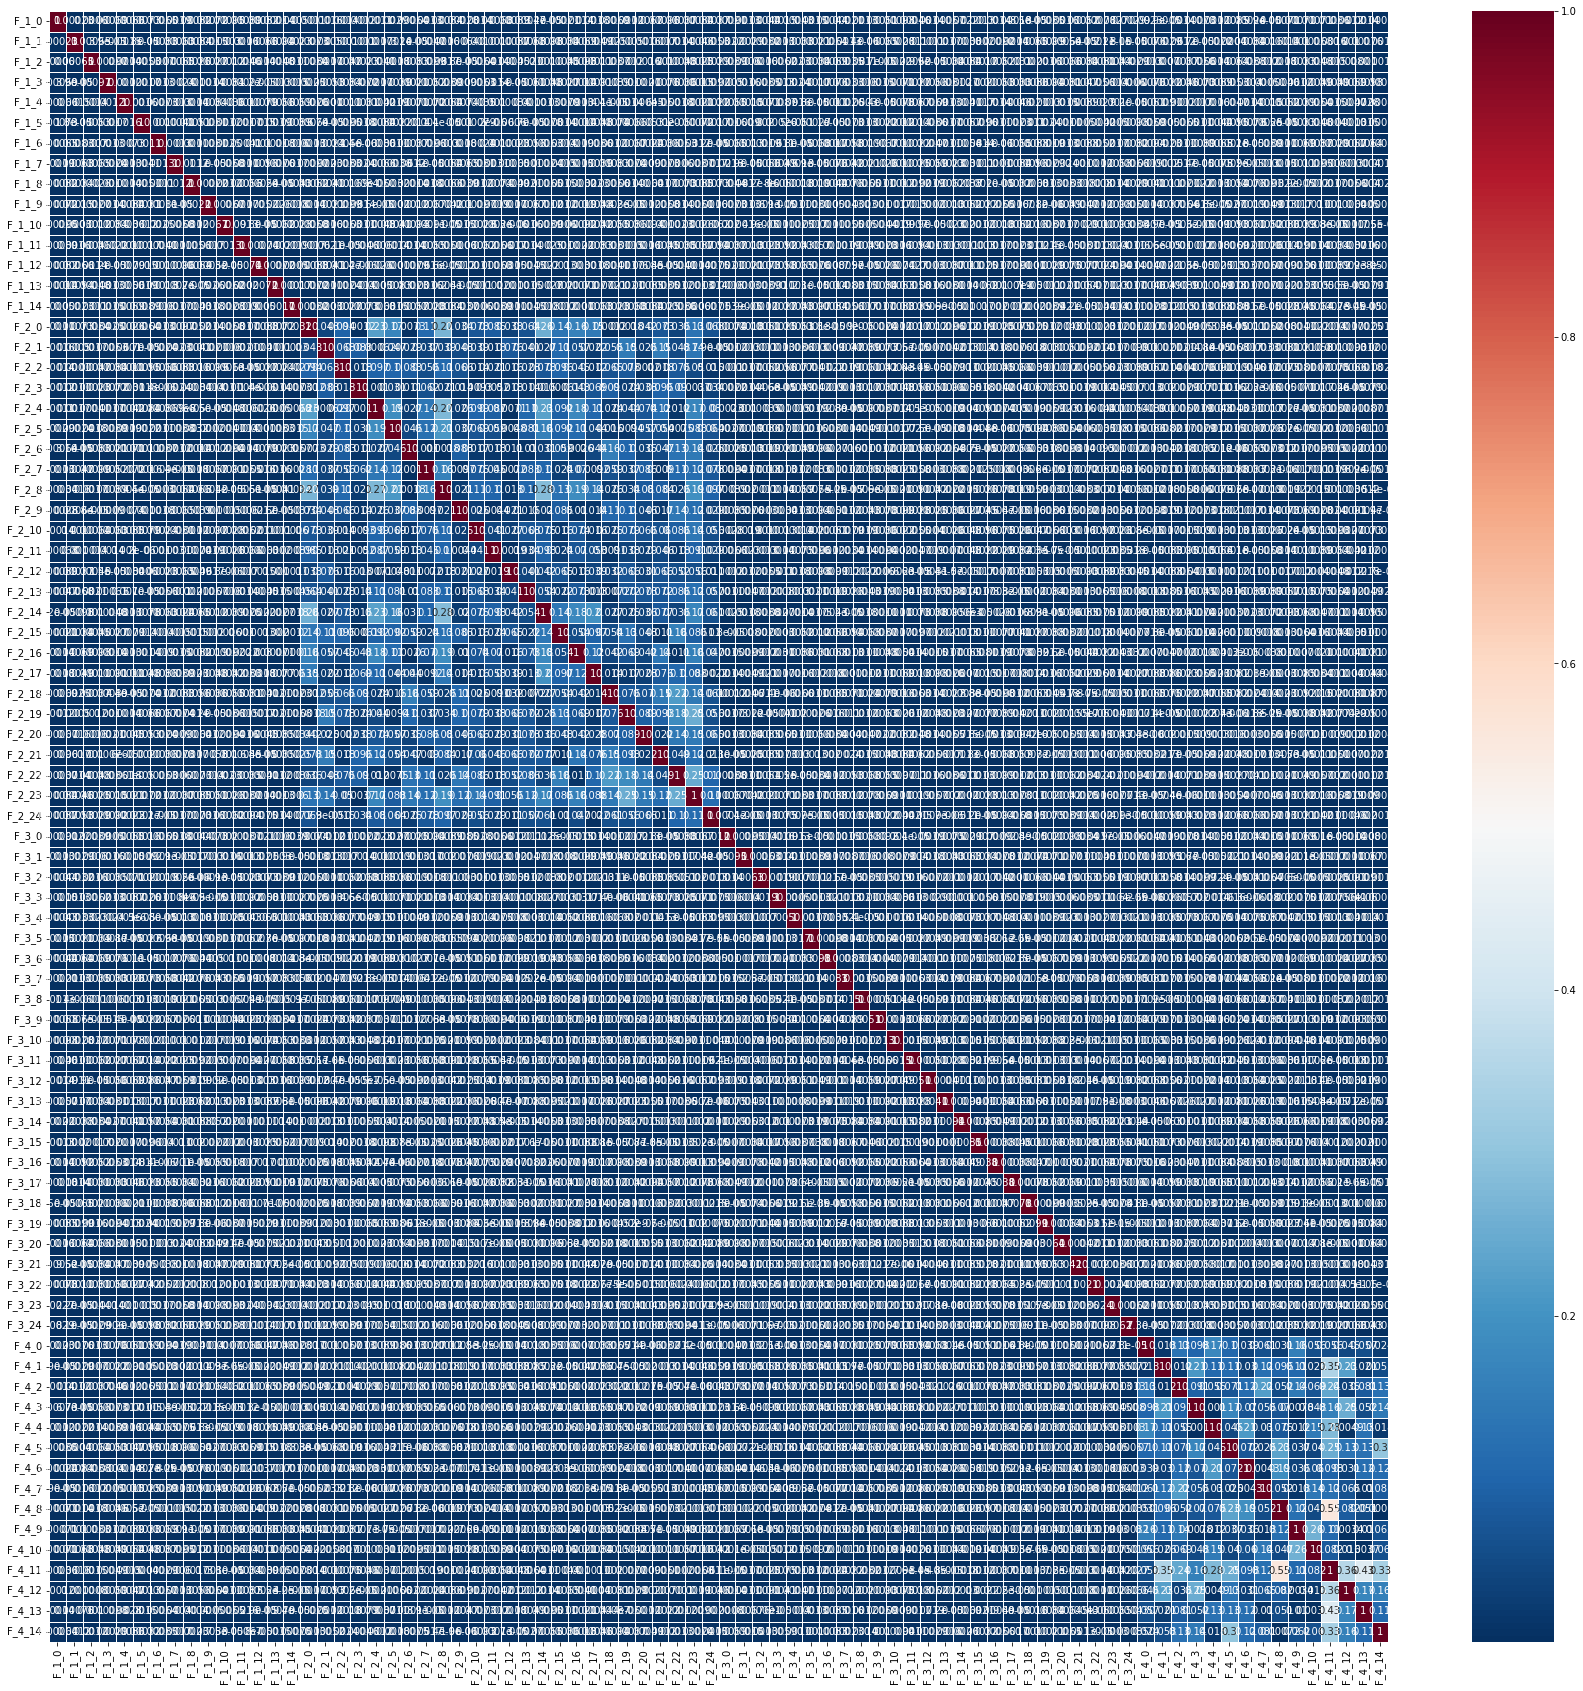

In [11]:
# correlation of all columns containing nans

pearsoncorr = data.corr()

plt.figure(figsize=(30, 30))
sns.heatmap(np.abs(pearsoncorr),
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

<AxesSubplot:>

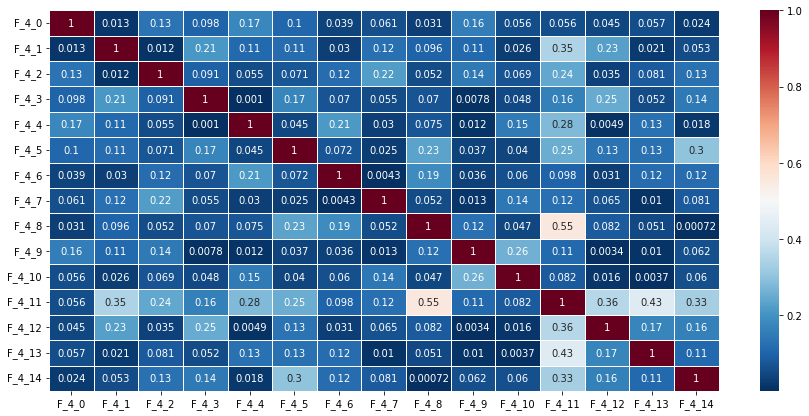

In [12]:
# shows correlations of columns starting with F_4 only

pearsoncorr_4 = pearsoncorr.loc[[row for row in pearsoncorr.index
                                 if row.split('_')[1] == '4'],
                                [col for col in pearsoncorr.columns
                                 if col.split('_')[1] == '4']]

plt.figure(figsize=(15, 7))
sns.heatmap(np.abs(pearsoncorr_4),
            xticklabels=pearsoncorr_4.columns,
            yticklabels=pearsoncorr_4.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [13]:
list_col_nans = [col for col in data.columns if data[col].isna().sum() != 0]

print(f"Columns with nans have an average of \
{round(data[list_col_nans].isna().mean().mean()*100, 2)} \
% nans with a mininum of \
{round(data[list_col_nans].isna().mean().min()*100, 2)} \
% of nans and a maximum of \
{round(data[list_col_nans].isna().mean().max()*100, 2)} \
% of nans")

Columns with nans have an average of 1.82 % nans with a mininum of 1.8 % of nans and a maximum of 1.85 % of nans


In [14]:
# defining the training scope for Bayesian Optimization of group 4 columns

list_col_4 = [col for col in data.columns if col.split('_')[1] == '4']
TARGET_COL = 'F_4_7'
TRAINING_SIZE = 500000

target_nan_idx = data[data[TARGET_COL].isnull()].index

train_set = data.drop(target_nan_idx, axis=0)
test_set = data[data.index.isin(target_nan_idx)]

X = train_set.drop([TARGET_COL], axis=1)
y = train_set[TARGET_COL]

subset_idx = random.sample(list(X.index), TRAINING_SIZE)

X = X.loc[subset_idx]
y = y.loc[subset_idx]

X.shape

(500000, 79)

In [15]:
dtrain = xgb.DMatrix(X, label=y)


def xgb_evaluate(max_depth, gamma, eta, colsample_bytree, min_child_weight):
    
    """ Function to maximize.
        Inputs are hyperparameters.
        Returns negative RMSE score."""
    
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': eta,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': int(min_child_weight)
             }

    cv_result = xgb.cv(params, dtrain, nfold=3)

    # Bayesian only knows how to maximize so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [16]:
%%time

xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (1, 10),
                                             'gamma': (0, 5),
                                             'eta': (0.01, 0.1),
                                             'colsample_bytree': (0.3, 0.9),
                                             'min_child_weight': (3,6)
                                            })

xgb_bo.maximize(init_points=5, n_iter=15, acq='ei')

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... |
-------------------------------------------------------------------------------------
|  1        | -2.271    |  0.5026   |  0.09879  |  4.461    |  2.618    |  4.845    |
|  2        | -2.202    |  0.7186   |  0.06399  |  0.7832   |  5.88     |  5.28     |
|  3        | -2.279    |  0.4487   |  0.02394  |  0.26     |  9.473    |  4.45     |
|  4        | -2.155    |  0.6322   |  0.06502  |  3.717    |  7.442    |  4.506    |
|  5        | -2.147    |  0.3696   |  0.08236  |  2.429    |  9.826    |  3.074    |
|  6        | -2.225    |  0.676    |  0.03247  |  0.3387   |  8.419    |  3.701    |
|  7        | -2.216    |  0.3375   |  0.06223  |  2.86     |  9.998    |  3.139    |
|  8        | -2.302    |  0.7061   |  0.02082  |  1.799    |  5.536    |  4.558    |
|  9        | -2.13     |  0.4264   |  0.08313  |  2.303    |  9.806    |  3.017    |
|  10       | -2.114    |  0.3623   |  0.1      |  2.0

In [17]:
# save the best hyperparameters

xgb_best_params = xgb_bo.max
best_max_depth = int(xgb_best_params['params']['max_depth'])
best_min_child_weight = int(xgb_best_params['params']['min_child_weight'])

xgb_best_params['params']['max_depth'] = best_max_depth
xgb_best_params['params']['min_child_weight'] = best_min_child_weight

xgb_best_params['model_name'] = 'xgb'
xgb_best_params

{'target': -2.037738814510217,
 'params': {'colsample_bytree': 0.9,
  'eta': 0.1,
  'gamma': 4.478999681172369,
  'max_depth': 7,
  'min_child_weight': 4},
 'model_name': 'xgb'}

In [18]:
dtrain = lgb.Dataset(data=X, label=y)


def lgb_eval(learning_rate, num_leaves, max_bin):
    """ Function to maximize.
        Inputs are hyperparameters.
        Returns negative RMSE score."""
    
    params = {'objective': 'regression',
              'learning_rate': learning_rate,
              'num_iterations': 500,
              'num_leaves': int(num_leaves),
              'max_bin': 50,
              'metric': 'rmse',
              'force_col_wise': 'true',
              'verbose': -1
             }
    
    cv_result = lgb.cv(params, train_set=dtrain, nfold=3, metrics='rmse', stratified=False)
    # Bayesian only knows how to maximize so return the negative RMSE

    return -1.0 * min(cv_result['rmse-mean'])

In [19]:
%%time

lgbBO = BayesianOptimization(lgb_eval,
                             {'learning_rate': (0.01, 0.02),
                              'num_leaves': (50, 150),
                              'max_bin': (255,1000)
                             })

lgbBO.maximize(init_points=5, n_iter=15, acq='ei')

|   iter    |  target   | learni... |  max_bin  | num_le... |
-------------------------------------------------------------
|  1        | -1.665    |  0.01066  |  907.7    |  54.43    |
|  2        | -1.457    |  0.01936  |  630.3    |  77.15    |
|  3        | -1.524    |  0.01779  |  288.1    |  57.49    |
|  4        | -1.46     |  0.01819  |  940.9    |  84.64    |
|  5        | -1.49     |  0.0123   |  860.0    |  143.6    |
|  6        | -1.591    |  0.01106  |  941.8    |  84.46    |
|  7        | -1.46     |  0.01927  |  529.4    |  76.7     |
|  8        | -1.587    |  0.01117  |  453.7    |  85.52    |
|  9        | -1.511    |  0.01615  |  799.2    |  73.68    |
|  10       | -1.452    |  0.0151   |  768.0    |  126.6    |
|  11       | -1.395    |  0.01938  |  676.7    |  120.7    |
|  12       | -1.407    |  0.01924  |  659.3    |  111.4    |
|  13       | -1.458    |  0.01601  |  388.0    |  108.6    |
|  14       | -1.506    |  0.01902  |  385.0    |  57.48    |
|  15   

In [20]:
# save the best hyperparameters

lgb_best_params = lgbBO.max

best_num_leaves = int(lgb_best_params['params']['num_leaves'])
best_max_bin = int(lgb_best_params['params']['max_bin'])

lgb_best_params['params']['num_leaves'] = best_num_leaves
lgb_best_params['params']['max_bin'] = best_max_bin

lgb_best_params['model_name'] = 'LGBM'
lgb_best_params

{'target': -1.3948364519785093,
 'params': {'learning_rate': 0.019379757567333077,
  'max_bin': 676,
  'num_leaves': 120},
 'model_name': 'LGBM'}

In [21]:
# identifying the best model with the best HP based on the results

all_results = [xgb_best_params, lgb_best_params]

best_target = all_results[0]['target']
best_model_name = all_results[0]['model_name']
best_params = all_results[0]['params']


for model_max in all_results:
    if model_max['target'] > best_target:
        best_target = model_max['target']
        best_model_name = model_max['model_name']
        best_params = model_max['params']

print("Model performing best is: ", best_model_name)

Model performing best is:  LGBM


In [22]:
# building the final model depending on the results

if best_model_name == 'xgb':
      best_model = xgb.XGBRegressor(
          n_estimators=5000,
          colsample_bytree=best_params['colsample_bytree'],
          eta=best_params['eta'],
          gamma=best_params['gamma'],
          max_depth=best_params['max_depth'],
          min_child_weight=best_params['min_child_weight']
                              )
elif best_model_name == 'LGBM':
      best_model = LGBMRegressor(
          n_estimators=20000,
          learning_rate=best_params['learning_rate'],
          num_iterations=30000,
          num_leaves=best_params['num_leaves'],
          max_bin=best_params['max_bin'],
          metric='rmse'
                    )

In [23]:
%%time

# training and predicting with the final model

predictions = {}

data_col_4 = data[list_col_4]

for target_col in list_col_4:
  
    target_nan_idx = data_col_4[data_col_4[target_col].isnull()].index
    train_set = data_col_4.drop(target_nan_idx, axis=0)
    test_set = data_col_4[data_col_4.index.isin(target_nan_idx)]


    X_train = train_set.drop([target_col], axis=1)
    y_train = train_set[target_col]
    X_test = test_set.loc[target_nan_idx].drop(target_col, axis=1)

    print('\nProcessing Column Name : ', target_col)
    best_model.fit(X_train, y_train)
    predictions[target_col] = best_model.predict(X_test)
    print(target_col, ' processed')


Processing Column Name :  F_4_0
F_4_0  processed

Processing Column Name :  F_4_1
F_4_1  processed

Processing Column Name :  F_4_2
F_4_2  processed

Processing Column Name :  F_4_3
F_4_3  processed

Processing Column Name :  F_4_4
F_4_4  processed

Processing Column Name :  F_4_5
F_4_5  processed

Processing Column Name :  F_4_6
F_4_6  processed

Processing Column Name :  F_4_7
F_4_7  processed

Processing Column Name :  F_4_8
F_4_8  processed

Processing Column Name :  F_4_9
F_4_9  processed

Processing Column Name :  F_4_10
F_4_10  processed

Processing Column Name :  F_4_11
F_4_11  processed

Processing Column Name :  F_4_12
F_4_12  processed

Processing Column Name :  F_4_13
F_4_13  processed

Processing Column Name :  F_4_14
F_4_14  processed
CPU times: user 1d 8h 44min 32s, sys: 9min 26s, total: 1d 8h 53min 59s
Wall time: 8h 22min 16s


In [24]:
for col in list(predictions.keys()):
    data[col][data[col].isna()] = predictions[col]

In [25]:
print(f"""Columns starting with F_4 now have \
{data[list_col_4].isna().sum().sum()} nans left""")

Columns starting with F_4 now have 0 nans left


In [26]:
imp = SimpleImputer(
         missing_values=np.nan,
         strategy='mean') 
data[:] = imp.fit_transform(data)

In [27]:
print(f"The whole dataset now has \
{data.isna().sum().sum()} nans left")

The whole dataset now has 0 nans left


In [28]:
PATH_SAMPLE = '../input/tabular-playground-series-jun-2022/sample_submission.csv'

submission = pd.read_csv(PATH_SAMPLE, index_col='row-col')
for i in tqdm(submission.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission.loc[i, 'value'] = data.loc[row, col]

submission.to_csv('submission.csv')

100%|██████████| 1000000/1000000 [01:44<00:00, 9612.88it/s]
